In [ ]:
# reload
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np

import matplotlib.pyplot as plt

import sys
sys.path.append('../')
import funPlots as fplot

import seaborn as sns
from scipy.stats import entropy

fplot.master_format(ncols = 2, nrows = 1)

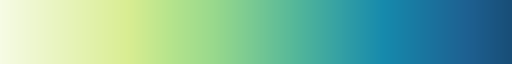

In [2]:
import matplotlib.patheffects as pe
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

colors = ["#F6FBE4", "#ECF6C9", "#E3F2AE", "#d9ed92", "#b5e48c", "#99d98c",
          "#76c893", "#52b69a", "#34a0a4", "#168aad", "#1a759f", "#1e6091", "#184e77"]
nodes = np.linspace(0, 1, len(colors))
cmap_SR = LinearSegmentedColormap.from_list("cmap_SR", list(zip(nodes, colors)))
cmap_SR.set_bad(color='w')
cmap_SR

In [5]:
from utils.simulation import *
from utils.mutual import (compute_mutual_information_from_trajectories, mutual_information_slowjumps, MC_underhood)
from utils.analytical import *

/home/barzon/.local/lib/python3.8/site-packages/numba/core/errors.py:175: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [3]:
data_folder = 'data/'

my_cmap_continuous = sns.color_palette('mako_r', as_cmap=True)

colors = ("#76c893", "#184e77")
labels = ('$E$', '$I$')

## Input projection

In [7]:
kmin, kmax = 0.01, 5
wmin, wmax = 1, 10
sigmah = 1

nk, nw = int(1e3), int(5e2)

ws = np.linspace(wmin, wmax, nw)
Ks = np.zeros((nw, nk))
Ws = np.zeros((nw, nk))

for idx_w, w in enumerate(ws):
    kcrit = 1 - 1/w
    if w <=1:
        k_list = np.linspace(kmin, kmax, nk)
    else:
        k_list = np.geomspace(1e-12, kcrit/2, 500) + kcrit
        k_list = np.concatenate([np.linspace(kcrit*(1 + 1/2), kmax, nk - 500), k_list])
    Ks[idx_w] = np.sort(k_list)
    Ws[idx_w] = w

unstable = np.where(1 + Ws*(Ks-1)<=0)

Istat = np.zeros(Ks.shape)
SDer = np.zeros(Ks.shape)

for idx_w, w in enumerate(ws):
    for idx_k, k in enumerate(Ks[idx_w]):
        if 1 + w*(k-1)<=0:
            Istat[idx_w, idx_k] = np.nan
            SDer[idx_w, idx_k] = np.nan
        else:
            Istat[idx_w, idx_k] = mutual_stat_input_global(w, k, sigmah)
            SDer[idx_w, idx_k] = mutual_second_der_global(w, k, sigmah)

Istat /= np.log(2)
SDer /= np.log(2)

/tmp/ipykernel_74059/3505079135.py:6: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  axs["cp_chi"].pcolormesh(Ks, Ws, SDer, cmap=cmap_SR, rasterized = True)
/tmp/ipykernel_74059/3505079135.py:25: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  axs["cp_ist"].pcolormesh(Ks, Ws, np.log10(Istat), cmap=cmap_SR, rasterized = True)
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family ['Avenir'] not found. Falling back to DejaVu Sans.
findfont: Font family '

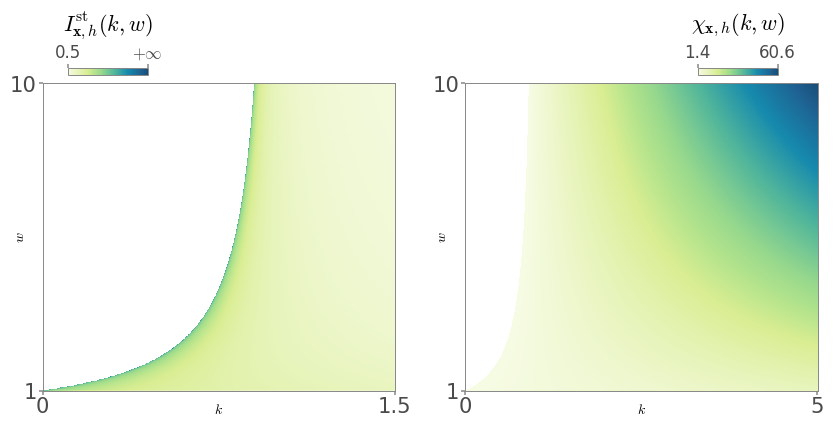

In [8]:
fig, axs = plt.subplot_mosaic([["cp_ist","cp_chi"]],
                               figsize = (10, 4),
                               gridspec_kw = {'width_ratios': [1, 1]})

plt.subplots_adjust(wspace=0.2, hspace=0.3)
axs["cp_chi"].pcolormesh(Ks, Ws, SDer, cmap=cmap_SR, rasterized = True)
axs["cp_chi"].set_xlabel('$k$', labelpad = -10)
axs["cp_chi"].set_ylabel('$w$', labelpad = -12)
#axs["cp_chi"].set_aspect(0.5)
axs["cp_chi"].set_yticks([1, 10])
axs["cp_chi"].set_xticks([0, 5])

chi_max = np.nanmax(SDer)
chi_min = np.nanmin(SDer)

cax = fig.add_axes([0.78, 0.9, 0.08, 0.0175])
cbar = plt.colorbar(axs["cp_chi"].collections[0], cax=cax, orientation='horizontal')
cax.xaxis.set_ticks_position('top')
cax.xaxis.set_label_position('top')
cbar.set_ticks([chi_min, chi_max])
cbar.set_ticklabels([f'{chi_min:.1f}', f'{chi_max:.1f}'], fontsize = 12)
cbar.set_label(r'$\chi_{\mathbf{x},h}(k, w)$', labelpad = 10, fontsize = 16)


axs["cp_ist"].pcolormesh(Ks, Ws, np.log10(Istat), cmap=cmap_SR, rasterized = True)
axs["cp_ist"].set_xlabel('$k$', labelpad = -10)
axs["cp_ist"].set_ylabel('$w$', labelpad = -12)
#axs["cp_ist"].set_aspect(0.3)
axs["cp_ist"].set_xlim(0.0,1.5)
axs["cp_ist"].set_xticks([0, 1.5])
axs["cp_ist"].set_xticklabels(["0", "1.5"])
axs["cp_ist"].set_yticks([1, 10])

ist_max = np.nanmax(np.log10(Istat))
ist_min = np.nanmin(np.log10(Istat))

cax = fig.add_axes([0.15, 0.9, 0.08, 0.0175])
cbar = plt.colorbar(axs["cp_ist"].collections[0], cax=cax, orientation='horizontal')
cax.xaxis.set_ticks_position('top')
cax.xaxis.set_label_position('top')
cbar.set_ticks([ist_min, ist_max])
cbar.set_ticklabels([f'{10**ist_min:.1f}', '$+\infty$'], fontsize = 12)
cbar.set_label(r'$I_{\mathbf{x},h}^\mathrm{st} (k, w)$', labelpad = 10, fontsize = 16)

plt.show()

# Nonlinear - delta_h = 0.15

In [21]:
### Info input
M = 3
tau_h = 100
wup = 1 / tau_h
wdown = 1 / tau_h
delta_h = 1.
D = 0.05
hs = np.arange(M) * delta_h
hs = np.stack([hs, np.zeros(M)])

W = create_transition_matrix_star_graph(M, wup, wdown)

p_stat = np.array([wdown] + [wup] * (M-1))
p_stat = p_stat / p_stat.sum()

In [22]:
ks = np.load(data_folder+f'k_list_nonlinear.npy')
ks_large = np.load(data_folder+f'k_list_nonlinear_large.npy')
n_runs = 10
tau_hs = [1000, 250] #[1000, 500, 250]
ws = [1, 2, 4, 6]

res_linear = np.zeros((len(tau_hs), len(ws), ks.size, n_runs))
res_nonlinear = np.zeros((len(tau_hs), len(ws), ks.size, n_runs))

for ih, tau_h in enumerate(tau_hs):
    for iw, w in enumerate(ws):
        tmp_res_linear = np.load(f'data/mutual_linear_w_{w}_tau_{tau_h}_dh_{delta_h}_k_{ks[0]}_{ks[-1]}_{ks.size}.npy')
        tmp_res_nonlinear = np.load(f'data/mutual_nonlinear_w_{w}_tau_{tau_h}_dh_{delta_h}_k_{ks[0]}_{ks[-1]}_{ks.size}.npy')
        
        res_linear[ih,iw] = tmp_res_linear
        res_nonlinear[ih,iw] = tmp_res_nonlinear
        
mi_imp_samp = np.zeros((len(ws), ks_large.size))

for i, w in enumerate(ws):
    mi_importance_sampling = np.load(data_folder+f'mutual_importance_sampling_fixedw{w}_deltah_{delta_h}_D_{D}.npy')
    mi_imp_samp[i] = mi_importance_sampling

findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not

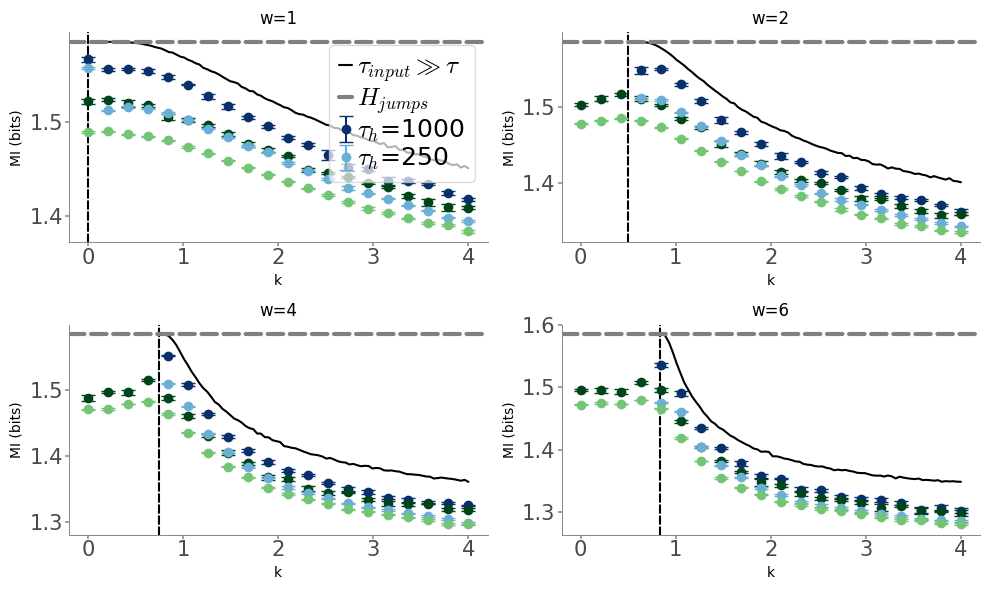

In [23]:
figsize=(10,6)
cmaps_lin = plt.get_cmap('Blues_r',len(tau_hs)+1)
cmaps_nonlin = plt.get_cmap('Greens_r',len(tau_hs)+1)

plt.figure(figsize=(10,6))

for i, w in enumerate(ws):
    mi_importance_sampling = mi_imp_samp[i]

    #plt.figure(figsize=(6,3))
    plt.subplot(2,len(ws)//2,i+1)
    
    for j, tau_h in enumerate(tau_hs):
        plt.errorbar(ks, res_linear[j,i].mean(axis=1), res_linear[j,i].std(axis=1) / np.sqrt(res_linear[j,i].shape[1]), label=r'$\tau_h$='+str(tau_h), fmt='o', capsize=5, c=cmaps_lin(j))
        plt.errorbar(ks, res_nonlinear[j,i].mean(axis=1), res_nonlinear[j,i].std(axis=1) / np.sqrt(res_linear[j,i].shape[1]), fmt='o', capsize=5, c=cmaps_nonlin(j))
    
    plt.plot(ks_large, mi_importance_sampling / np.log(2), '-', label=r'$\tau_{input}\gg \tau$', c='k', zorder=0)

    plt.axvline(1-1/w, c='k', ls='--', zorder=-1)
    plt.axhline(entropy(p_stat) / np.log(2), c='gray', ls='--', lw=3, label=r'$H_{jumps}$', zorder=1)

    plt.xlabel('k')
    plt.ylabel('MI (bits)')
    plt.title(f'w={w}')

    if i==0: plt.legend()
        
plt.tight_layout()
sns.despine()
plt.show()        

# Nonlinear - delta_h = 0.15

In [25]:
### Info input
M = 3
tau_h = 100
wup = 1 / tau_h
wdown = 1 / tau_h
delta_h = 0.15
D = 0.001
hs = np.arange(M) * delta_h
hs = np.stack([hs, np.zeros(M)])

W = create_transition_matrix_star_graph(M, wup, wdown)

p_stat = np.array([wdown] + [wup] * (M-1))
p_stat = p_stat / p_stat.sum()

In [26]:
ks = np.load(data_folder+f'k_list_nonlinear.npy')
ks_large = np.load(data_folder+f'k_list_nonlinear_large.npy')
n_runs = 10
tau_hs = [1000, 250] #[1000, 500, 250]
ws = [1, 2, 4, 6]

res_linear = np.zeros((len(tau_hs), len(ws), ks.size, n_runs))
res_nonlinear = np.zeros((len(tau_hs), len(ws), ks.size, n_runs))

for ih, tau_h in enumerate(tau_hs):
    for iw, w in enumerate(ws):
        tmp_res_linear = np.load(f'data/mutual_linear_w_{w}_tau_{tau_h}_dh_{delta_h}_k_{ks[0]}_{ks[-1]}_{ks.size}.npy')
        tmp_res_nonlinear = np.load(f'data/mutual_nonlinear_w_{w}_tau_{tau_h}_dh_{delta_h}_k_{ks[0]}_{ks[-1]}_{ks.size}.npy')
        
        res_linear[ih,iw] = tmp_res_linear
        res_nonlinear[ih,iw] = tmp_res_nonlinear
        
mi_imp_samp = np.zeros((len(ws), ks_large.size))

for i, w in enumerate(ws):
    mi_importance_sampling = np.load(data_folder+f'mutual_importance_sampling_fixedw{w}_deltah_{delta_h}_D_{D}.npy')
    mi_imp_samp[i] = mi_importance_sampling

findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not

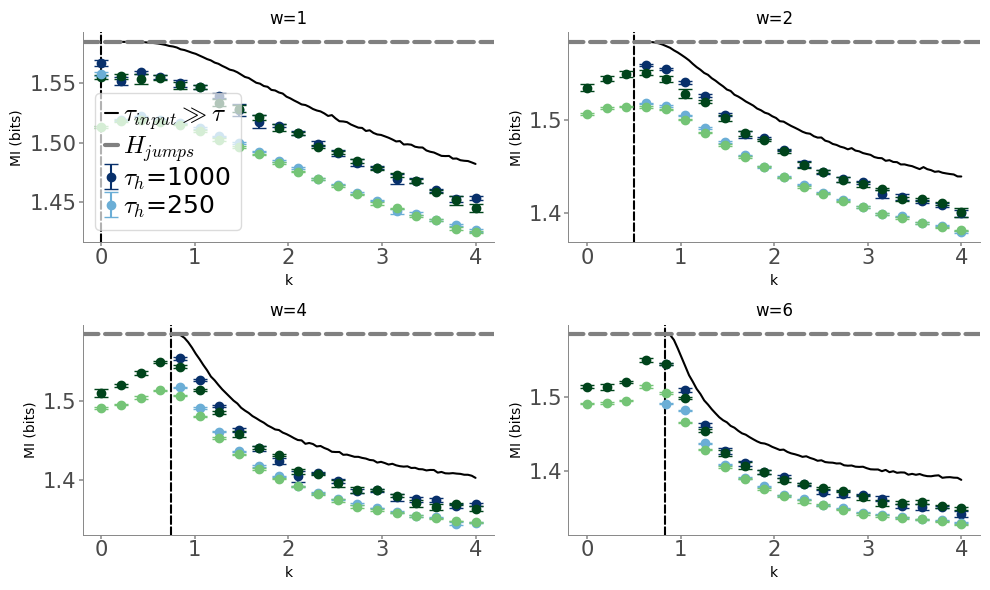

In [28]:
figsize=(10,6)
cmaps_lin = plt.get_cmap('Blues_r',len(tau_hs)+1)
cmaps_nonlin = plt.get_cmap('Greens_r',len(tau_hs)+1)

plt.figure(figsize=(10,6))

for i, w in enumerate(ws):
    mi_importance_sampling = mi_imp_samp[i]

    #plt.figure(figsize=(6,3))
    plt.subplot(2,len(ws)//2,i+1)
    
    for j, tau_h in enumerate(tau_hs):
        plt.errorbar(ks, res_linear[j,i].mean(axis=1), res_linear[j,i].std(axis=1) / np.sqrt(res_linear[j,i].shape[1]), label=r'$\tau_h$='+str(tau_h), fmt='o', capsize=5, c=cmaps_lin(j))
        plt.errorbar(ks, res_nonlinear[j,i].mean(axis=1), res_nonlinear[j,i].std(axis=1) / np.sqrt(res_linear[j,i].shape[1]), fmt='o', capsize=5, c=cmaps_nonlin(j))
    
    plt.plot(ks_large, mi_importance_sampling / np.log(2), '-', label=r'$\tau_{input}\gg \tau$', c='k', zorder=0)

    plt.axvline(1-1/w, c='k', ls='--', zorder=-1)
    plt.axhline(entropy(p_stat) / np.log(2), c='gray', ls='--', lw=3, label=r'$H_{jumps}$', zorder=1)

    plt.xlabel('k')
    plt.ylabel('MI (bits)')
    plt.title(f'w={w}')

    if i==0: plt.legend()
        
plt.tight_layout()
sns.despine()
plt.show()        